In [ ]:
from google.colab import drive
drive.mount("./drive")

Drive already mounted at ./drive; to attempt to forcibly remount, call drive.mount("./drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import plot_model
!pip install livelossplot
from livelossplot import PlotLossesKeras
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
import os
from PIL import Image
import cv2
from collections import Counter
!pip install imutils
from imutils import *
from scipy.spatial.distance import cosine, euclidean
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
!pip install plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly as ply
from sklearn.metrics import *
ply.offline.init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
VAL_LOC = "/content/drive/MyDrive/MIAS_Data/Val"
TRAIN_LOC = "/content/drive/MyDrive/MIAS_Data/Train"
TEST_LOC = "/content/drive/MyDrive/MIAS_Data/Test"

In [ ]:
train_data = TRAIN_LOC
val_data = VAL_LOC
masked_data = TEST_LOC
train_names = []; val_names = []; masked_names = []
train_names_count = []; val_names_count = []; masked_names_count = []

for class_ in sorted(os.listdir(train_data)):
    train_names.append(class_)
    train_names_count.append(len(os.listdir(os.path.join(train_data, class_))))

for class_ in sorted(os.listdir(val_data)):
    val_names.append(class_)
    val_names_count.append(len(os.listdir(os.path.join(val_data, class_))))

for class_ in sorted(os.listdir(masked_data)):
    masked_names.append(class_)
    masked_names_count.append(len(os.listdir(os.path.join(masked_data, class_))))

In [ ]:
fig = make_subplots(rows=1, cols=3)
fig.add_trace(go.Bar(name='training', x=train_names, y=train_names_count), row = 1, col = 1)
fig.add_trace(go.Bar(name='validation', x=val_names, y=val_names_count), row = 1, col = 2)
fig.add_trace(go.Bar(name='testing', x=masked_names, y=masked_names_count), row = 1, col = 3)
fig.update_layout(title_text="Data", title_x = 0.5)
fig.show(renderer='colab')

In [ ]:
num_classes=3
def list_of_shapes(img_location, name):
    shapes = []
    for img in os.listdir(os.path.join(img_location, name)):
        img_arr = cv2.imread(os.path.join(img_location, name, img))
        shapes.append(img_arr.shape)
    
    return shapes

In [ ]:
# G_train_shapes = list_of_shapes(train_data, "G")
# D_train_shapes = list_of_shapes(train_data, "D")
# F_train_shapes = list_of_shapes(train_data, "F")


# G_val_shapes = list_of_shapes(val_data, "G")
# D_val_shapes = list_of_shapes(val_data, "D")
# F_val_shapes = list_of_shapes(val_data, "F")


# shapes = G_train_shapes + D_train_shapes + G_val_shapes + D_val_shapes + F_train_shapes + F_val_shapes 
# widths = [shape[1] for shape in shapes]
# heights = [shape[0] for shape in shapes]

In [ ]:
IMG_SHAPE = (224,224,3)
def euclidean_distance(vectors):
	# unpack the vectors into separate lists
	(featsA, featsB) = vectors

	# compute the sum of squared distances between the vectors
	sumSquared = K.sum(K.square(featsA - featsB), axis=1,
		keepdims=True)

	# return the euclidean distance between the vectors
	return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [ ]:
def make_pairs(images, labels):
	# initialize two empty lists to hold the (image, image) pairs and
	# labels to indicate if a pair is positive or negative
	pairImages = []
	pairLabels = []

	# calculate the total number of classes present in the dataset
	# and then build a list of indexes for each class label that
	# provides the indexes for all examples with a given label
	numClasses = len(np.unique(labels))
 
	idx = [np.where(labels == i)[0] for i in range(0,3)]

	# loop over all images
	for idxA in range(len(images)):
		# grab the current image and label belonging to the current
		# iteration
		currentImage = images[idxA]
		label = labels[idxA]

		# randomly pick an image that belongs to the *same* class
		# label
		idxB = np.random.choice(idx[label])
		posImage = images[idxB]

		# prepare a positive pair and update the images and labels
		# lists, respectively
		pairImages.append([currentImage, posImage])
		pairLabels.append([1])

		# grab the indices for each of the class labels *not* equal to
		# the current label and randomly pick an image corresponding
		# to a label *not* equal to the current label
		negIdx = np.where(labels != label)[0]
		negImage = images[np.random.choice(negIdx)]

		# prepare a negative pair of images and update our lists
		pairImages.append([currentImage, negImage])
		pairLabels.append([0])

	# return a 2-tuple of our image pairs and labels
	return (np.array(pairImages), np.array(pairLabels))

In [ ]:
def load_data(img_location, name):
    imgs = []
    labels = []
    for img in os.listdir(os.path.join(img_location, name)):
        img_arr = cv2.imread(os.path.join(img_location, name, img))
        img_arr=cv2.cvtColor(img_arr,cv2.COLOR_BGR2RGB)
        #img_arr=img_arr/255
        img_arr = cv2.resize(img_arr, (IMG_SHAPE[1], IMG_SHAPE[0]))
        labels.append(name)
        imgs.append(img_arr)
    
    return imgs, labels    

In [ ]:
G_train_imgs, G_train_labels = load_data(train_data,"G")
D_train_imgs, D_train_labels = load_data(train_data,"D")
G_val_imgs, G_val_labels = load_data(val_data,"G")
D_val_imgs, D_val_labels = load_data(val_data,"D")
F_train_imgs, F_train_labels = load_data(train_data,"F")
F_val_imgs, F_val_labels = load_data(val_data,"F")

train_imgs = G_train_imgs + D_train_imgs + F_train_imgs 
train_labels = G_train_labels + D_train_labels + F_train_labels 

val_imgs = G_val_imgs + D_val_imgs +F_val_imgs 
val_labels = G_val_labels + D_val_labels +F_val_labels 
train_imgs = np.array(train_imgs)
val_imgs = np.array(val_imgs)

train_imgs.shape, val_imgs.shape

((225, 224, 224, 3), (68, 224, 224, 3))

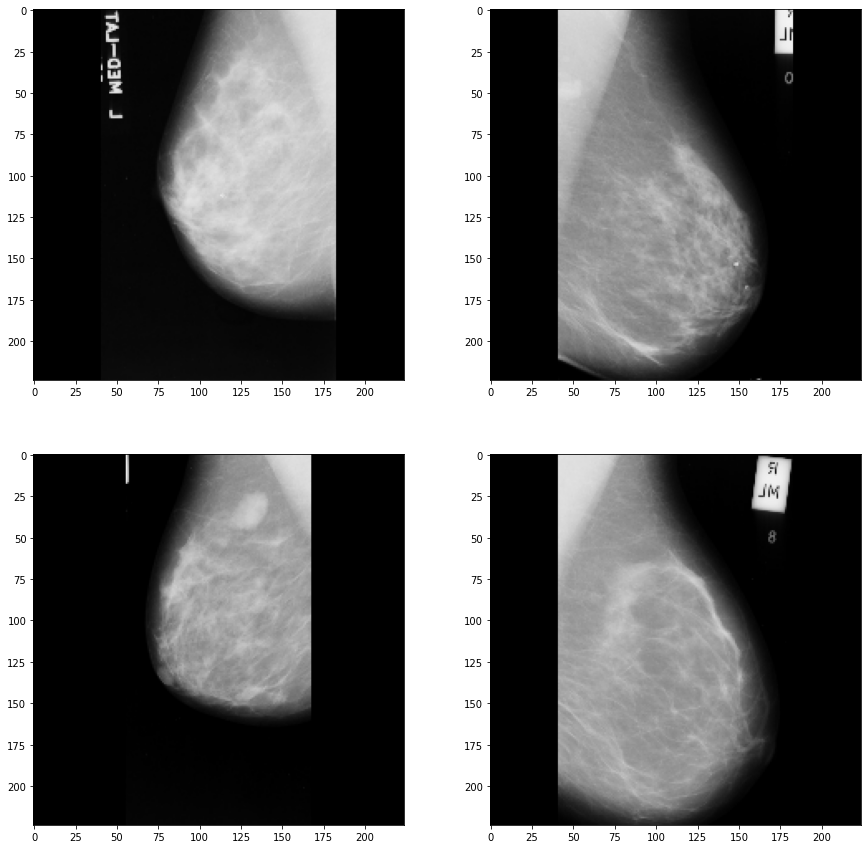

In [ ]:
fig=plt.figure(figsize=(15,15))
columns = 2
rows = 2
for i in range(1, columns*rows +1):
    img = np.random.randint(10)
    fig.add_subplot(rows, columns, i)
    plt.imshow(train_imgs[i])
plt.show()

In [ ]:
from collections import Counter
print(Counter(train_labels))
print(Counter(val_labels))

Counter({'D': 78, 'F': 74, 'G': 73})
Counter({'D': 24, 'G': 22, 'F': 22})


In [ ]:
train_enc_labels = []; val_enc_labels = []

encoding = dict({"G" : 0, "D" : 1, "F" : 2 })
for label in train_labels:
    train_enc_labels.append(encoding[label])

for label in val_labels:
    val_enc_labels.append(encoding[label])

train_enc_labels = np.array(train_enc_labels, "int")
val_enc_labels = np.array(val_enc_labels, "int")

In [ ]:
print(f"train_imgs shape : {train_imgs.shape}")
print(f"val_imgs shape : {val_imgs.shape}")
print(f"train_enc_labels shape : {train_enc_labels.shape}")
print(f"val_enc_labels shape : {val_enc_labels.shape}")

train_imgs shape : (225, 224, 224, 3)
val_imgs shape : (68, 224, 224, 3)
train_enc_labels shape : (225,)
val_enc_labels shape : (68,)


In [ ]:
train_pairs, train_pair_labels = make_pairs(train_imgs, train_enc_labels)
val_pairs, val_pair_labels = make_pairs(val_imgs, val_enc_labels)

In [ ]:
print(f"train_pairs shape : {train_pairs.shape}")
print(f"val_pairs shape : {val_pairs.shape}")
print(f"train_pair_labels shape : {train_pair_labels.shape}")
print(f"val_pair_labels shape : {val_pair_labels.shape}")

train_pairs shape : (450, 2, 224, 224, 3)
val_pairs shape : (136, 2, 224, 224, 3)
train_pair_labels shape : (450, 1)
val_pair_labels shape : (136, 1)


The images pairs will not appear if we have normalized the image data


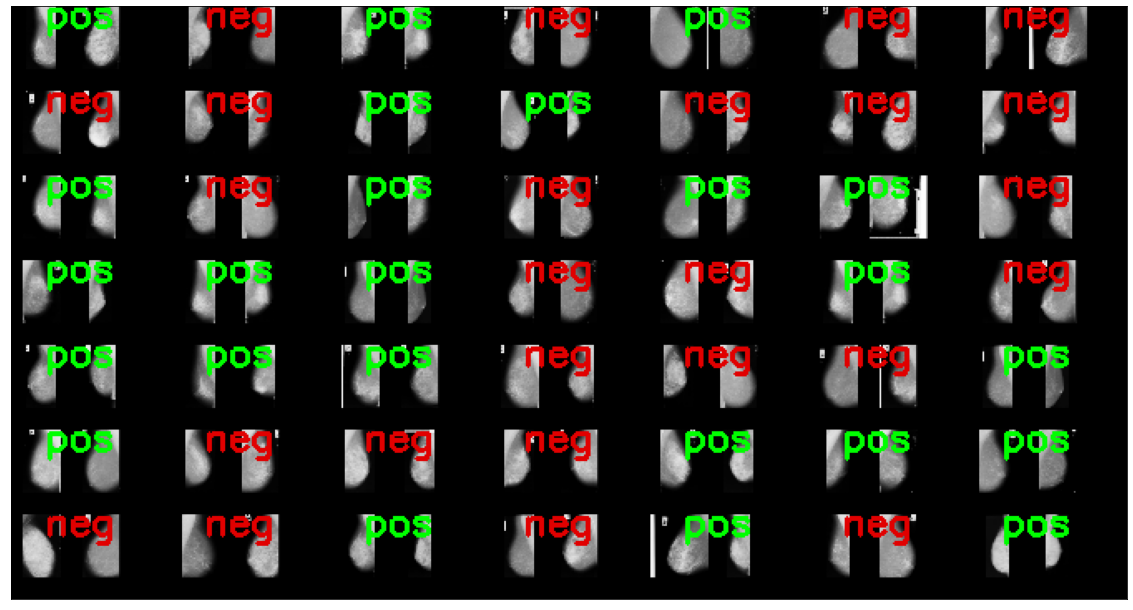

In [ ]:
images = []
for i in np.random.choice(np.arange(0, len(train_pairs)), size=(100,)):
	# grab the current image pair and label
	imageA = train_pairs[i][0]
	imageB = train_pairs[i][1]
	label = train_pair_labels[i]
	# to make it easier to visualize the pairs and their positive or
	# negative annotations, we're going to "pad" the pair with two
	# pixels along the top, bottom, and right borders, respectively
	output = np.zeros((300, 600, 3), dtype="uint8")
	pair = np.hstack([imageA, imageB])
	output[2:226, 2:450,:] = pair
	# set the text label for the pair along with what color we are
	# going to draw the pair in (green for a "positive" pair and
	# red for a "negative" pair)
	text = "neg" if label[0] == 0 else "pos"
	color = (225, 0, 0) if label[0] == 0 else (0, 255, 0)
	# create a 3-channel RGB image from the grayscale pair, resize
	# it from 60x36 to 96x51 (so we can better see it), and then
	# draw what type of pair it is on the image
	vis = cv2.merge([output])
	vis = cv2.resize(vis, (96, 51), interpolation=cv2.INTER_LINEAR)
	cv2.putText(vis, text, (20, 12), cv2.FONT_HERSHEY_SIMPLEX, 0.75, color, 2)
	# add the pair visualization to our list of output images
	images.append(vis)
# construct the montage for the images
montage = build_montages(images, (96, 51), (7, 7))[0]
# show the output montage
plt.figure(figsize=(20, 20))
plt.xticks([])
plt.yticks([])
print("The images pairs will not appear if we have normalized the image data")
plt.imshow(montage);
plt.imsave("Montage.jpeg", montage)

In [ ]:
def build_siamese_model(inputShape, embeddingDim=48):
	# specify the inputs for the feature extractor network
	inputs = Input(inputShape)

	# define the first set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(16, (2, 2), padding="same", activation="relu")(inputs)
	x = MaxPooling2D(pool_size=(2, 2))(x)
#	x = Dropout(0.3)(x)

	# second set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(32, (2, 2), padding="same", activation="relu")(x)
	x = MaxPooling2D(pool_size=2)(x)
#	x = Dropout(0.3)(x)
 
 
	# second set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(64, (2, 2), padding="same", activation="relu")(x)
	x = MaxPooling2D(pool_size=2)(x)
#	x = Dropout(0.3)(x)
 
 
	# second set of CONV => RELU => POOL => DROPOUT layers
	x = Conv2D(128, (2, 2), padding="same", activation="relu")(x)
	x = MaxPooling2D(pool_size=2)(x)
#	x = Dropout(0.3)(x)

	# prepare the final outputs
	pooledOutput = GlobalAveragePooling2D()(x)
	outputs = Dense(embeddingDim, name="Emdedding")(pooledOutput)

	# build the model
	model = Model(inputs, outputs)

	# return the model to the calling function
	return model

In [ ]:
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)
featureExtractor = build_siamese_model(IMG_SHAPE, 128)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

# finally, construct the siamese network
distance = Lambda(euclidean_distance, name="Euclidean_distance")([featsA, featsB])
outputs = Dense(1, activation="sigmoid", name="similarity")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs, name="SiameseNetwork")
model.compile(loss="binary_crossentropy", optimizer="adam",	metrics=["accuracy"])

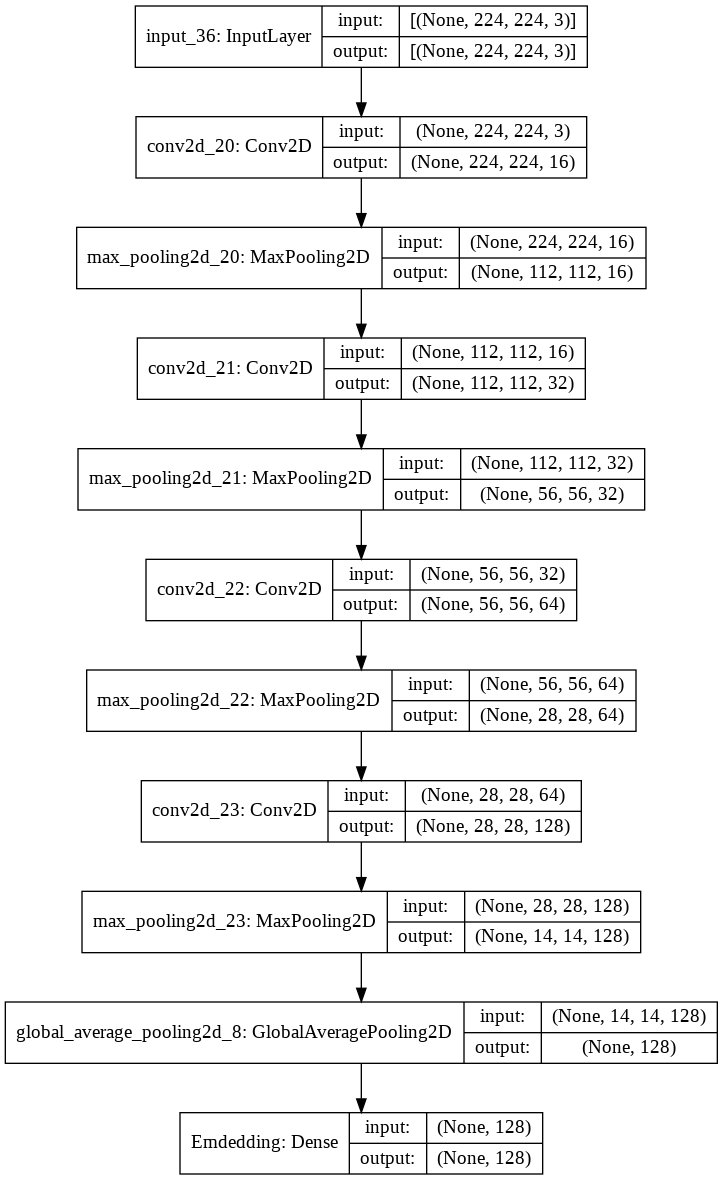

In [ ]:
plot_model(featureExtractor, to_file='featureExtractor.png', show_shapes=True, show_layer_names=True)

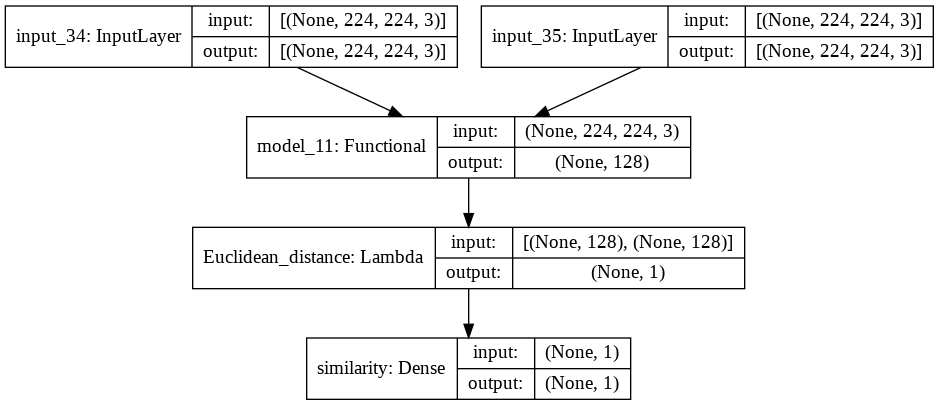

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
featureExtractor.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 28, 28, 64)        0  

In [ ]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_35 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_11 (Functional)           (None, 128)          59952       input_34[0][0]                   
                                                                 input_35[0][0]                   
__________________________________________________________________________________________________
Euclidean_distance (Lambda)     (None, 1)            0           model_11[0][0]      

In [ ]:
EPOCHS = 100
c1= PlotLossesKeras()
c2=EarlyStopping(monitor="val_loss",
    min_delta=0,
    patience=0,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True)

In [ ]:
print(train_pairs[:, 0].shape)
print(train_pair_labels[:].shape)

(450, 224, 224, 3)
(450, 1)


In [ ]:
x_train = np.array([train_pairs[:, 0], train_pairs[:, 1]])
y_train = train_pair_labels[:]
x_val = np.array([val_pairs[:, 0], val_pairs[:, 1]])
y_val = val_pair_labels[:]

print(f"x_train shape : {x_train.shape}")
print(f"y_train shape : {y_train.shape}")
print(f"x_val shape : {x_val.shape}")
print(f"y_val shape : {y_val.shape}")

x_train shape : (2, 450, 224, 224, 3)
y_train shape : (450, 1)
x_val shape : (2, 136, 224, 224, 3)
y_val shape : (136, 1)


In [ ]:
# model.compile(optimizer='adam',metrics=['accuracy'],loss='binary_crossentropy')

In [ ]:
# x_t=tf.convert_to_tensor([train_pairs[:, 0], train_pairs[:, 1]])
# y_t=tf.convert_to_tensor(train_pair_labels[:])
# x_v=tf.convert_to_tensor([val_pairs[:, 0], val_pairs[:, 1]])
# y_v=tf.convert_to_tensor(val_pair_labels[:])

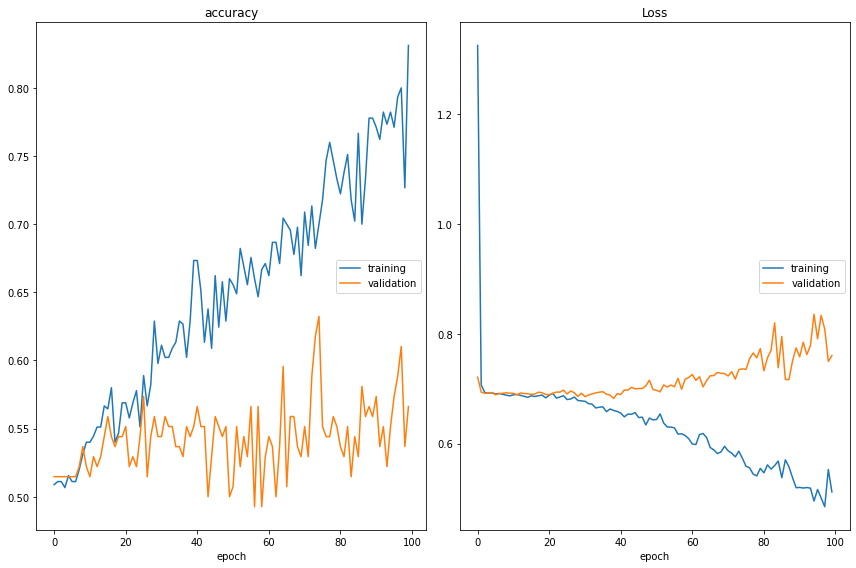

accuracy
	training         	 (min:    0.507, max:    0.831, cur:    0.831)
	validation       	 (min:    0.493, max:    0.632, cur:    0.566)
Loss
	training         	 (min:    0.485, max:    1.325, cur:    0.512)
	validation       	 (min:    0.682, max:    0.836, cur:    0.760)


In [ ]:
BATCH_SIZE = 32; EPOCHS = 100
c1=PlotLossesKeras()
train_history = model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_pair_labels[:],
                          validation_data = ([val_pairs[:, 0], val_pairs[:, 1]], val_pair_labels[:]),
                          batch_size = BATCH_SIZE,
                          epochs = EPOCHS,
                          callbacks=[c1])